In [ ]:
from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

bert = AutoModel.from_pretrained("vinai/phobert-base")

In [ ]:
bert

RobertaModel(
  (embeddings): RobertaEmbeddings(
    (word_embeddings): Embedding(64001, 768, padding_idx=1)
    (position_embeddings): Embedding(258, 768, padding_idx=1)
    (token_type_embeddings): Embedding(1, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): RobertaEncoder(
    (layer): ModuleList(
      (0-11): 12 x RobertaLayer(
        (attention): RobertaAttention(
          (self): RobertaSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): RobertaSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (dr

In [ ]:
!pip install underthesea

In [ ]:
!pip install transformers torch

In [ ]:
!pip install gensim

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

# Misc.
import warnings
warnings.filterwarnings('ignore')

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

from transformers import get_linear_schedule_with_warmup, AutoTokenizer, AutoModel, logging

import warnings
warnings.filterwarnings("ignore")

logging.set_verbosity_error()

In [ ]:
def seed_everything(seed_value):
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed_everything(86)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
EPOCHS = 5
N_SPLITS = 5

In [ ]:
# prompt: connect drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
root_path = "/content/drive/MyDrive/"
data_path = "Colab Notebooks/data_combine.csv"
df = pd.read_csv(root_path + data_path, encoding='utf-8')

df.head()

,star,category,product,star_riel,comments,lowercase,remove_dot,remove_number,replace_acronyms,replace_incorrect_word,generated_text,corrected_text
0,0,dtdd,iphone-15-pro-max,5,ok,ok,ok,ok,tốt,tốt,[{'generated_text': 'tốt.'}],tốt.
1,1,dtdd,iphone-15-pro-max,3,mua ngày đầu tiên sạc 100 dùng fb zalo tiktok ...,mua ngày đầu tiên sạc 100 dùng fb zalo tiktok ...,mua ngày đầu tiên sạc 100 dùng fb zalo tiktok ...,mua ngày đầu tiên sạc dùng fb zalo tiktok dc t...,mua ngày đầu tiên sạc dùng facebook zalo tikto...,mua ngày đầu tiên sạc dùng facebook zalo tikto...,[{'generated_text': 'Mấy ngày đầu tiên sạc dùn...,Mấy ngày đầu tiên sạc dùng facebook zalo tikto...
2,2,dtdd,iphone-15-pro-max,5,sản phẩm tốt chất lượng nhân viên tư vấn tgdđ ...,sản phẩm tốt chất lượng nhân viên tư vấn tgdđ ...,sản phẩm tốt chất lượng nhân viên tư vấn tgdđ ...,sản phẩm tốt chất lượng nhân viên tư vấn tgdđ ...,sản phẩm tốt chất lượng nhân viên tư vấn thế g...,sản phẩm tốt chất lượng nhân viên tư vấn thế g...,"[{'generated_text': 'Sản phẩm tốt, chất lượng ...","Sản phẩm tốt, chất lượng nhân viên tư vấn thế ..."
3,3,dtdd,iphone-15-pro-max,5,mới mua được 3 hôm lướt web với fb thôi mà cũn...,mới mua được 3 hôm lướt web với fb thôi mà cũn...,mới mua được 3 hôm lướt web với fb thôi mà cũn...,mới mua được hôm lướt web với fb thôi mà cũng ...,mới mua được hôm lướt web với facebook thôi mà...,mới mua được hôm lướt web với facebook thôi mà...,[{'generated_text': 'Mới mua được hôm lướt web...,Mới mua được hôm lướt web với facebook thôi mà...
4,4,dtdd,iphone-15-pro-max,3,tạm ổn,tạm ổn,tạm ổn,tạm ổn,tạm ổn,tạm ổn,[{'generated_text': 'Tạm ổn.'}],Tạm ổn.


In [ ]:
from underthesea import word_tokenize
print(df.shape)
print(df.columns.tolist())


# loại bỏ cột bằng rỗng hoặc
df = df[df['corrected_text'] != '']
df = df.dropna(subset=['corrected_text'])
df.drop_duplicates(subset="corrected_text", inplace=True, keep=False)

df['name_token_count'] = df['corrected_text'].apply(lambda x: len(word_tokenize(x)))

print(df.shape)

# loại bỏ cột có số lượng token tự nhỏ hơn 1 và lớn hơn 150
df = df[df['name_token_count'] >= 2]
df = df[df['name_token_count'] <= 150]
df = df.loc[:, ['star_riel', 'corrected_text', 'name_token_count']]
print(df.shape)



(24465, 12)
['star', 'category', 'product', 'star_riel', 'comments', 'lowercase', 'remove_dot', 'remove_number', 'replace_acronyms', 'replace_incorrect_word', 'generated_text', 'corrected_text']
(19889, 13)
(19830, 3)


In [ ]:
from sklearn.utils import resample
def map_star(x):
    if x in [1, 2, 3]:
        return 0
    elif x in [4, 5]:
        return 1

# Áp dụng hàm lambda cho cột 'star' và tạo một cột mới 'new_star'
# df['star.1'] = df['star'].apply(lambda x: map_star(x))
df['sentiment'] = df['star_riel'].apply(lambda x: map_star(x))

In [ ]:
comments = df[['sentiment', 'corrected_text']]
comments.head()


,sentiment,corrected_text
1,0,Mấy ngày đầu tiên sạc dùng facebook zalo tikto...
2,1,"Sản phẩm tốt, chất lượng nhân viên tư vấn thế ..."
3,1,Mới mua được hôm lướt web với facebook thôi mà...
5,1,Nhân viên tư vấn thân thiệt và nhiệt tình.
6,1,Sao pin con này bị sao vậy shock?.


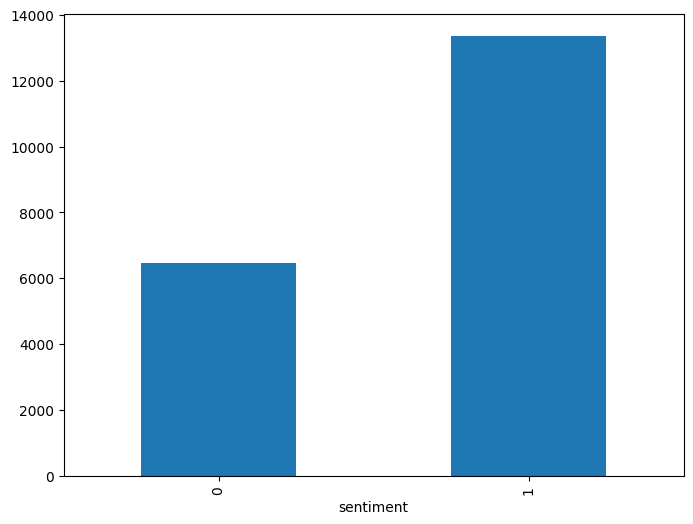

In [ ]:
# Check the distriution of complaints by category
# Lets plot it and see
fig = plt.figure(figsize=(8,6))
comments.groupby('sentiment').sentiment.count().plot.bar(ylim=0)
plt.show()

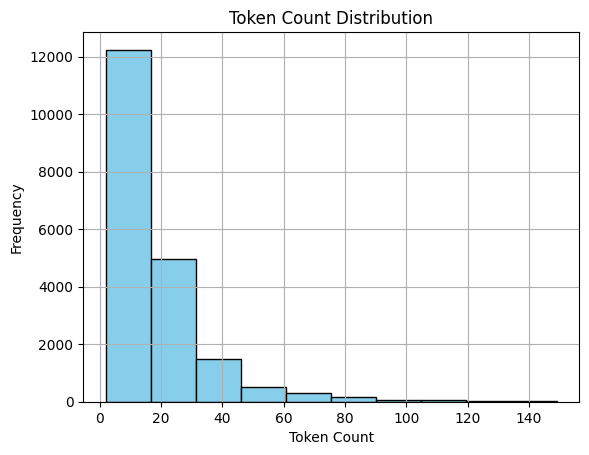

In [ ]:

# Vẽ biểu đồ
plt.hist(df['name_token_count'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Token Count')
plt.ylabel('Frequency')
plt.title('Token Count Distribution')
plt.grid(True)
plt.show()

In [ ]:
# bỏ bớt
count_class_0, count_class_1 = comments['sentiment'].value_counts()

undersampled_size = min(count_class_0, count_class_1) + 2000

df_class_0 = comments[comments['sentiment'] == 0]
df_class_1 = comments[comments['sentiment'] == 1]

df_class_1_undersampled = resample(df_class_1, replace= False, n_samples=undersampled_size, random_state=42)

comments = pd.concat([df_class_0, df_class_1_undersampled])

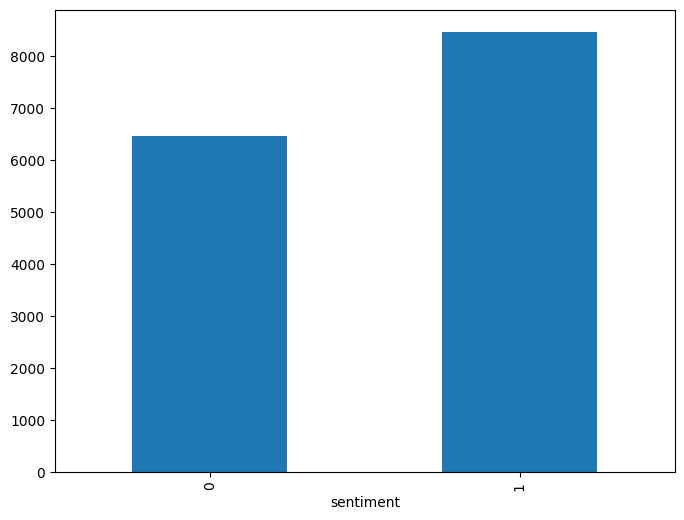

In [ ]:
# Check the distriution of complaints by category
# Lets plot it and see
fig = plt.figure(figsize=(8,6))
comments.groupby('sentiment').sentiment.count().plot.bar(ylim=0)
plt.show()

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

In [ ]:
class SentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=150):
        self.df = df
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        """
        To customize dataset, inherit from Dataset class and implement
        __len__ & __getitem__
        __getitem__ should return
            data:
                input_ids
                attention_masks
                text
                targets
        """
        row = self.df.iloc[index]
        text, label = self.get_input_data(row)

        # Encode_plus will:
        # (1) split text into token
        # (2) Add the '[CLS]' and '[SEP]' token to the start and end
        # (3) Truncate/Pad sentence to max length
        # (4) Map token to their IDS
        # (5) Create attention mask
        # (6) Return a dictionary of outputs
        encoding = self.tokenizer.encode_plus(
            text,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_masks': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(label, dtype=torch.long),
        }

    def get_input_data(self, row):
        # Preprocessing: {remove icon, special character, lower}
        text = row['corrected_text']
        label = row['sentiment']

        return text, label

In [ ]:
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)
        nn.init.normal_(self.fc.weight, std=0.02)
        nn.init.normal_(self.fc.bias, 0)

    def forward(self, input_ids, attention_mask):
        last_hidden_state, output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=False # Dropout will errors if without this
        )

        x = self.drop(output)
        x = self.fc(x)
        return x

In [ ]:
def train_model(model, criterion, optimizer, train_loader):
    model.train()
    losses = []
    correct = 0
    print(1)
    for data in train_loader:
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        loss = criterion(outputs, targets)
        _, pred = torch.max(outputs, dim=1)

        correct += torch.sum(pred == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

    print(f'Train Accuracy: {correct.double()/len(train_loader.dataset)} Loss: {np.mean(losses)}')

def eval_model(data_loader, test_data = False):
    losses = []
    correct = 0

    with torch.no_grad():
        for data in data_loader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_masks'].to(device)
            targets = data['targets'].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, pred = torch.max(outputs, dim=1)

            loss = criterion(outputs, targets)
            correct += torch.sum(pred == targets)
            losses.append(loss.item())

    if test_data:
        print(f'Test Accuracy: {correct.double()/len(data_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(data_loader.dataset)
    else:
        print(f'Valid Accuracy: {correct.double()/len(data_loader.dataset)} Loss: {np.mean(losses)}')
        return correct.double()/len(data_loader.dataset)

In [ ]:
train, test = train_test_split(comments, test_size=0.2, random_state=0)

In [ ]:
train, valid = train_test_split(train, test_size=0.125, random_state=0)

In [ ]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10451 entries, 0 to 10450
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sentiment       10451 non-null  int64 
 1   corrected_text  10451 non-null  object
dtypes: int64(1), object(1)
memory usage: 163.4+ KB


In [ ]:
train_dataset = SentimentDataset(train, tokenizer, max_len=150)
valid_dataset = SentimentDataset(valid, tokenizer, max_len=150)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, num_workers=2)

model = SentimentClassifier(n_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
# Recommendation by BERT: lr: 5e-5, 2e-5, 3e-5
# Batchsize: 16, 32
optimizer = AdamW(model.parameters(), lr=2e-5)

lr_scheduler = get_linear_schedule_with_warmup(
                optimizer,
                num_warmup_steps=0,
                num_training_steps=len(train_loader)*EPOCHS
            )
best_acc = 0
for epoch in range(EPOCHS):
    print(f'Epoch {epoch+1}/{EPOCHS}')
    print('-'*30)
    train_model(model, criterion, optimizer, train_loader)
    val_acc = eval_model(valid_loader)

    if val_acc > best_acc:
        torch.save(model.state_dict(), f'phobert_epoch{epoch+1}.pth')
        best_acc = val_acc

Epoch 1/5
------------------------------
1
Train Accuracy: 0.8629796191751985 Loss: 0.3283345635399359
Valid Accuracy: 0.8821954484605087 Loss: 0.317294605551882
Epoch 2/5
------------------------------
1
Train Accuracy: 0.9120658310209548 Loss: 0.24239764846747439
Valid Accuracy: 0.8688085676037482 Loss: 0.3207808908946971
Epoch 3/5
------------------------------
1
Train Accuracy: 0.9327337096928523 Loss: 0.19672783410293407
Valid Accuracy: 0.8882195448460508 Loss: 0.3146271904375642
Epoch 4/5
------------------------------
1
Train Accuracy: 0.9509137881542435 Loss: 0.15369422084706
Valid Accuracy: 0.8862115127175367 Loss: 0.37559746832963314
Epoch 5/5
------------------------------
1
Train Accuracy: 0.9631614199598124 Loss: 0.1218413303218873
Valid Accuracy: 0.8862115127175367 Loss: 0.41454525929479363


In [ ]:
def test_model(data_loader):
    model = SentimentClassifier(n_classes=2)
    model.to(device)
    model.load_state_dict(torch.load('phobert_epoch3.pth'))
    model.eval()

    texts = []
    predicts = []
    predict_probs = []
    real_values = []

    for data in data_loader:
        text = data['text']
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_masks'].to(device)
        targets = data['targets'].to(device)

        with torch.no_grad():
                outputs = model(
                    input_ids=input_ids,
                    attention_mask=attention_mask
                )
        _, pred = torch.max(outputs, dim=1)
        texts.extend(text)
        predicts.extend(pred)
        real_values.extend(targets)

    predicts = torch.stack(predicts).cpu()
    real_values = torch.stack(real_values).cpu()
    print(classification_report(real_values, predicts))
    return real_values, predicts

In [ ]:
test_dataset = SentimentDataset(test, tokenizer, max_len=150)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=2)
real_values, predicts = test_model(test_loader)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1274
           1       0.93      0.88      0.90      1713

    accuracy                           0.89      2987
   macro avg       0.89      0.89      0.89      2987
weighted avg       0.89      0.89      0.89      2987



In [ ]:
def infer(model, text, tokenizer, max_len=120):
    encoded_review = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt',
    )



    input_ids = encoded_review['input_ids'].to(device)
    attention_mask = encoded_review['attention_mask'].to(device)

    output = model(input_ids, attention_mask)
    _, y_pred = torch.max(output, dim=1)

    print(f'Text: {text}')
    print(f'Sentiment: {y_pred}')



In [ ]:
    model = SentimentClassifier(n_classes=2)
    model.to(device)
    model.load_state_dict(torch.load('phobert_epoch3.pth'))
    model.eval()

SentimentClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [ ]:
infer(model, 'Máy dùng khá ổn, lần sau sẽ ủng hộ', tokenizer)

infer(model, 'Sản phẩm tệ, quá thất vọng', tokenizer)

infer(model, 'Sản phẩm khá, nhân viên nhiệt tinh', tokenizer)

Text: Máy dùng khá ổn, lần sau sẽ ủng hộ
Sentiment: tensor([1], device='cuda:0')
Text: Sản phẩm tệ, quá thất vọng
Sentiment: tensor([0], device='cuda:0')
Text: Sản phẩm khá, nhân viên nhiệt tinh
Sentiment: tensor([1], device='cuda:0')


In [ ]:
import os
os.listdir()


['.config',
 'phobert_epoch2.pth',
 '.gradio',
 'phobert_epoch1.pth',
 'drive',
 'phobert_epoch3.pth',
 'sample_data']

# **tạo giao diện gradio**


In [ ]:
!pip install transformers underthesea gradio

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification


In [ ]:
from transformers import AutoTokenizer
import torch
import torch.nn as nn

# Load tokenizer PhoBERT
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base", use_fast=False)

# Tạo lại đúng kiến trúc model
class SentimentClassifier(nn.Module):
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = AutoModel.from_pretrained("vinai/phobert-base")
        self.drop = nn.Dropout(p=0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, n_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1]
        return self.fc(self.drop(pooled_output))

# Khởi tạo model với đúng số lớp (2)
model = SentimentClassifier(n_classes=2)
model.load_state_dict(torch.load("phobert_epoch3.pth", map_location=torch.device('cpu')))
model.eval()


SentimentClassifier(
  (bert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm)

In [ ]:
def predict_sentiment(text):
    # Bước 1: Token hóa
    encoding = tokenizer.encode_plus(
        text,
        truncation=True,
        add_special_tokens=True,
        max_length=150,
        padding='max_length',
        return_attention_mask=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids']
    attention_mask = encoding['attention_mask']

    # Bước 2: Dự đoán
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs
        predicted_class = torch.argmax(logits, dim=1).item()

    # Bước 3: Nhãn (chỉ 2 lớp)
    label_map = {0: "Tiêu cực", 1: "Tích cực"}
    return label_map[predicted_class]


In [ ]:
import gradio as gr

iface = gr.Interface(
    fn=predict_sentiment,
    inputs=gr.Textbox(lines=4, label="Nhập câu đánh giá"),
    outputs=gr.Label(label="Kết quả cảm xúc"),
    title="Dự đoán cảm xúc tiếng Việt với PhoBERT",
    description="Ứng dụng demo phân tích cảm xúc văn bản bằng mô hình PhoBERT"
)

iface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9e17f86cf7513d0ded.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
